In [38]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn
from sklearn.decomposition import PCA

# Load data and create datasets

In [39]:
datastore = h5py.File('trials6.h5', 'r')
batch_size = 100
n_comp = 40

raw_I = np.array(datastore["I"])
raw_c = np.array(datastore["c"])
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

pcaI = PCA(n_components=n_comp)
pcaI.fit(raw_I)
pcac = PCA(n_components=n_comp)
pcac.fit(raw_c)

data_I = torch.tensor(pcaI.transform(raw_I)).to(device)
data_c = torch.tensor(pcac.transform(raw_c)).to(device)

dataset = TensorDataset(data_I, data_c)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using mps device


# Define the model

In [40]:
class VarTransform(nn.Module):
    def __init__(self):
        super(VarTransform, self).__init__()

    def forward(self, x):
        # exp of the 4th input value; pass others unchanged
        x[:, 3] = torch.exp(x[:, 3])
        return x

class net(nn.Module):
    def __init__(self, n_components, width):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_components, 80),
            nn.ReLU(),
            nn.Linear(80, width),
            nn.ReLU(),
            nn.Linear(width, 80),
            nn.ReLU(),
            nn.Linear(80, n_components),
        )

    def forward(self, x):
        y = self.layers(x)
        return y
    
class net_thin(nn.Module):
    def __init__(self, n_components, width):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_components, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, n_components),
        )

    def forward(self, x):
        y = self.layers(x)
        return y

In [41]:
model = net_thin(n_comp,200).to(device)
print(model)

net_thin(
  (layers): Sequential(
    (0): Linear(in_features=40, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=40, bias=True)
  )
)


# Training

In [42]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error: Avg loss = {test_loss:>8f} \n")

In [43]:
learning_rate = 2e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 80
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 9.845612  [  100/32000]
loss: 2.239641  [10100/32000]
loss: 2.451591  [20100/32000]
loss: 1.353659  [30100/32000]
Test Error: Avg loss = 1.712580 

Epoch 2
-------------------------------
loss: 1.443312  [  100/32000]
loss: 1.195512  [10100/32000]
loss: 0.421396  [20100/32000]
loss: 0.333712  [30100/32000]
Test Error: Avg loss = 0.466470 

Epoch 3
-------------------------------
loss: 0.431415  [  100/32000]
loss: 0.533654  [10100/32000]
loss: 0.219289  [20100/32000]
loss: 0.207588  [30100/32000]
Test Error: Avg loss = 0.199578 

Epoch 4
-------------------------------
loss: 0.134083  [  100/32000]
loss: 0.179104  [10100/32000]
loss: 0.106577  [20100/32000]
loss: 0.135765  [30100/32000]
Test Error: Avg loss = 0.109494 

Epoch 5
-------------------------------
loss: 0.100489  [  100/32000]
loss: 0.110596  [10100/32000]
loss: 0.079334  [20100/32000]
loss: 0.043793  [30100/32000]
Test Error: Avg loss = 0.103995 

Epoch 6
----------------------

# Inspecting results

In [17]:
model(data_I[10:13])

tensor([[-2.3331e+01,  2.0062e+00, -2.3100e-01,  8.8578e-02,  1.1640e-01,
         -1.0421e-01,  9.8217e-02, -8.5957e-02,  6.7530e-02, -7.5173e-02,
          5.5993e-02,  1.9473e-02],
        [-1.4473e+01, -2.5744e+00,  2.3776e+00, -1.6819e+00,  1.3557e+00,
         -9.9776e-01,  7.4011e-01, -5.2053e-01,  3.6801e-01, -2.8485e-01,
          1.8915e-01,  1.2644e-01],
        [ 6.3731e-01, -9.1651e+00,  4.6851e+00, -2.1218e+00,  8.2773e-01,
         -1.0418e-01, -1.7861e-01,  3.0164e-01, -3.1043e-01,  2.5228e-01,
         -1.7823e-01, -1.3340e-01]], device='mps:0', grad_fn=<LinearBackward0>)

In [22]:
data_c[10:13]

tensor([[-23.1954,   2.0849,  -0.3179,   0.0522,   0.1040,  -0.0732,   0.0952,
          -0.0736,   0.0732,  -0.0583,   0.0525,   0.0421],
        [-14.3085,  -2.4845,   2.3054,  -1.6995,   1.3485,  -0.9876,   0.7282,
          -0.5176,   0.3703,  -0.2722,   0.1955,   0.1448],
        [  0.6812,  -9.2772,   4.6765,  -2.1234,   0.7961,  -0.1149,  -0.2183,
           0.3080,  -0.3010,   0.2498,  -0.1826,  -0.1244]], device='mps:0')

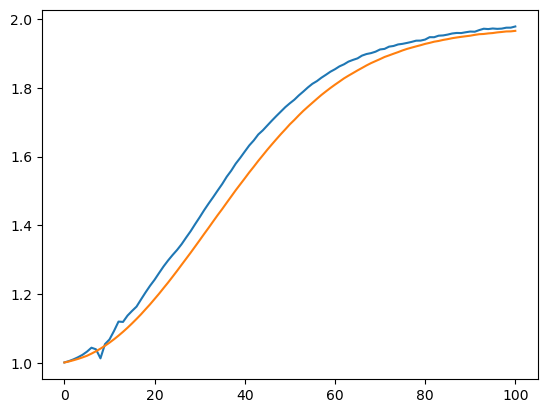

In [55]:
example = 2150
with torch.no_grad():
    x, y = test_dataset[example]
    plt.plot(pcac.inverse_transform(model(x).cpu()))
    plt.plot(pcac.inverse_transform(y.cpu()))
plt.show()

# RMS error in time series

In [45]:
with torch.no_grad():
    test_osmo_pred = np.zeros((0, 101))
    test_osmo_actual = np.zeros((0, 101))
    for (x, y) in test_dataloader:
        test_osmo_pred = np.vstack((test_osmo_pred, pcac.inverse_transform(model(x).cpu())))
        test_osmo_actual = np.vstack((test_osmo_actual, pcac.inverse_transform(y.cpu())))
    train_osmo_pred = np.zeros((0, 101))
    train_osmo_actual = np.zeros((0, 101))
    for (x, y) in train_dataloader:
        train_osmo_pred = np.vstack((train_osmo_pred, pcac.inverse_transform(model(x).cpu())))
        train_osmo_actual = np.vstack((train_osmo_actual, pcac.inverse_transform(y.cpu())))

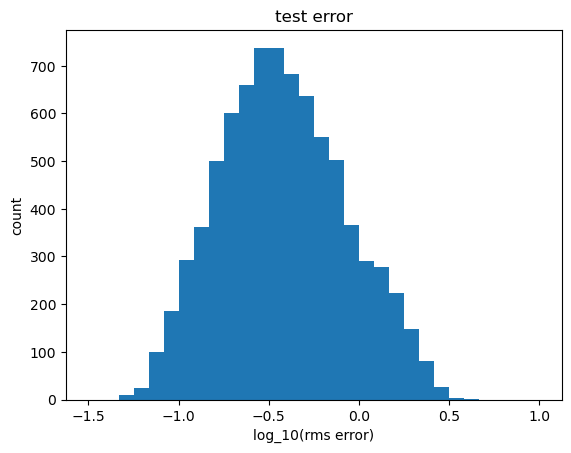

In [46]:
rmserror = np.apply_along_axis(np.linalg.norm, 1, test_osmo_pred - test_osmo_actual)
plt.hist(np.log10(rmserror), bins=np.linspace(-1.5,1,31))
plt.xlabel('log_10(rms error)')
plt.ylabel('count')
plt.title('test error')
plt.show()

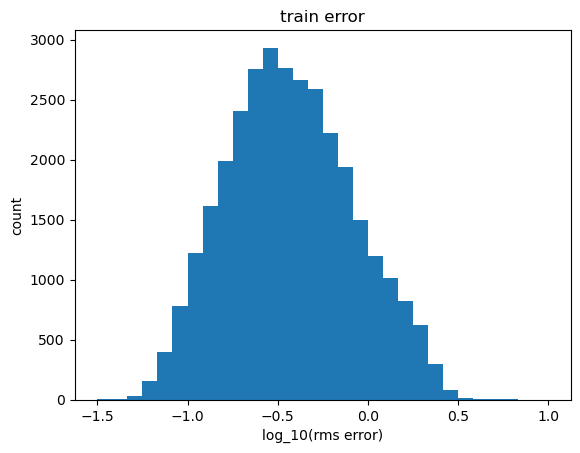

In [47]:
rmserror = np.apply_along_axis(np.linalg.norm, 1, train_osmo_pred - train_osmo_actual)
plt.hist(np.log10(rmserror), bins=np.linspace(-1.5,1,31))
plt.xlabel('log_10(rms error)')
plt.ylabel('count')
plt.title('train error')
plt.show()

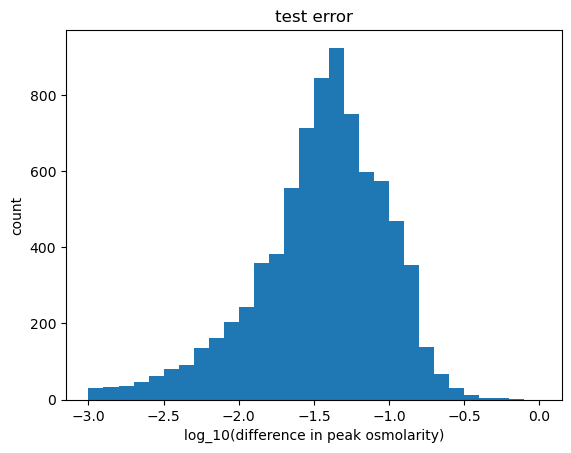

In [48]:
peakerror = np.max(test_osmo_pred, axis=1) - np.max(test_osmo_actual, axis=1)
plt.hist(np.log10(np.abs(peakerror)), bins=np.linspace(-3,0,31))
plt.xlabel('log_10(difference in peak osmolarity)')
plt.ylabel('count')
plt.title('test error')
plt.show()

In [56]:
#torch.save(model.state_dict(), 'model_osm_pca_size_40x200')